# NN2

This feed-forward neural network has two hiden layer. <br>
First: 350 neurons. <br>
Second: 40 neurons. <br>

First, we load the packages.

In [1]:
import pandas as pd
import numpy as np
from PIL import Image    
from sklearn.utils import shuffle
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from matplotlib import pyplot

Then, we divide the data in train and validation (0.9 and 0.1). Also,we define the read function. We extract the 32x32 center of the image.

In [1]:
data = pd.read_csv("newdata.csv")
data =shuffle(data)
n = round((data.shape[0]-1)*0.9)

train = data[1:n]
val = data[n:]

def readimage(n_batch, n, X):
    batch = []
    for i in range(n):
        path = "train/" + X.iloc[i+n*n_batch]['id']+ ".tif"
        img = cv2.imread(path) 
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)[32:32+32, 32:32+32]
        batch.append(np.moveaxis(img, -1,0))
        
    return torch.tensor(np.array(batch)).float()

Hidden layer 1: 350 neurons.<br>
Activation function: Leaky_relu. <br>
BatchNorm. <br> <br>

Hidden layer 2: 40 neurons. <br>
Activation function: Leaky_relu. <br>
Inizialization: Xavier-Uniform. <br>
Output: Sigmoid of unique value. <br>
Cost function: Binary Cross Entropy with logit loss. <br>
Batch size: 174.<br>
Epochs: 100. <br>
Size of input : 3072.

In [3]:
n_n1 = 350
n_n2 = 40
n_batch = 174
n_size = 3072
n_val = val.shape[0]
it = round(train.shape[0]/n_batch)
max_value = 255

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_size, n_n1, bias=True)
        self.batch=nn.BatchNorm1d(n_n1)
        self.fc2 = nn.Linear(n_n1,n_n2, bias=True)
        self.fc3=nn.Linear(n_n2, 1, bias=True)
        
    def forward(self, x):
        x = F.leaky_relu(self.batch(self.fc1(x)))
        x = F.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        return torch.sigmoid(x)
    
def init_weights(m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(1)
    
net=Net()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.8)
# create a loss function
criterion = nn.BCELoss()

l=[]
val_loss=[]
for epoch in range(100):
    train=shuffle(train)
    z=0
    for i in range(it):
        data=readimage(i, n_batch, train)
        data = data/max_value
        data=np.reshape(data, (n_batch, n_size))
        data = torch.Tensor(data)
        target = torch.Tensor(train['label'][n_batch*i:n_batch*(i+1)].values)
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        net_out = net(data)
        loss = criterion(net_out.view(n_batch,1), target.view(n_batch,1))
        loss.backward()
        optimizer.step()
        z+=loss.item()
    l.append(z/it)
    data = readimageval(0,n_val, val)
    data = data/max_value
    data=torch.Tensor(np.reshape(data, (n_val, n_size)))
    target = torch.Tensor(val['label'].values)
    data, target = Variable(data), Variable(target)
    with torch.no_grad(): # 1) As do not want to update G 
         net_out = net(data) 
    val_loss.append( criterion(net_out.view(21983,1), target.view(n_val,1)).item())
    print(l[epoch], val_loss[epoch], epoch)

0.6394065840787393 0.6099114418029785 0
0.6017884643012846 0.5936746597290039 1
0.5894769080500909 0.5835911631584167 2
0.580477843157744 0.5754969716072083 3
0.572849871929843 0.5689783096313477 4
0.5670751954446053 0.5638793706893921 5
0.5625667481068046 0.5598726272583008 6
0.5586025747638474 0.556703507900238 7
0.5557775359302628 0.5541999340057373 8
0.5531578038015592 0.5520708560943604 9
0.5512749715237211 0.5503126382827759 10
0.5493344829181044 0.5487901568412781 11
0.547700081934715 0.5473443269729614 12
0.5463386345245174 0.5460901856422424 13
0.5447777908626311 0.5449615120887756 14
0.5436098915291335 0.5439236164093018 15
0.5424513579358526 0.5428224205970764 16
0.5411799231326255 0.5420576333999634 17
0.5398960763043024 0.5409544706344604 18
0.5387802256390832 0.5400574207305908 19
0.5379184877652291 0.5394084453582764 20
0.5366960301300676 0.5383989810943604 21
0.535607531077 0.5375547409057617 22
0.5345256734072585 0.5368185639381409 23
0.5334538315720169 0.5360597372055

Learning curve.

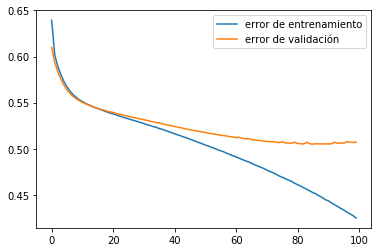

In [11]:

plt.plot(range(len(l)), l,label='error de entrenamiento')
plt.plot(range(len(l)), val_loss, label='error de validación')
plt.legend(loc="upper right")
plt.xlabel()

ROC curve.

AUC: 0.823
AUC NO SKILL: 0.500


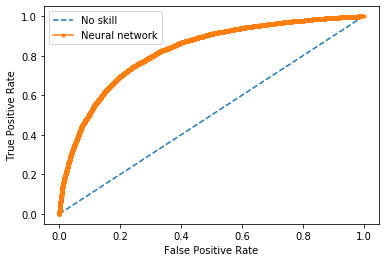

In [6]:
data=readimage(n_val )
data=data/max_value
data=np.reshape(data, (n_val ,n_size))
data = torch.Tensor(data.float())
target = val['label'].values
data=Variable(data)
with torch.no_grad(): # 1) As do not want to update G 
    net_out = torch.sigmoid(net(data) )

n_prob = [0 for _ in range(len(target))]


fpr1, tpr1, thresholds = roc_curve(target, net_out, pos_label = 1)
fpr2, tpr2, thresholds = roc_curve(target, n_prob, pos_label = 1)
auc1 = roc_auc_score(target, net_out)
auc2 = roc_auc_score(target, n_prob)
print('AUC: %.3f' % auc1)
print('AUC NO SKILL: %.3f' % auc2)
pyplot.plot(fpr2, tpr2, linestyle='--', label='No skill')
pyplot.plot(fpr1, tpr1, marker='.', label='Neural network')

pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

pyplot.legend()

pyplot.show()
    